## Topic Analysis and Word Frequency Visualization of Canadian Federal Liberal and Conservative Party Leaders' Tweets

David Dvorak

August 21, 2021

Here I visualize the results of the topic analysis using pyLDAvis. I am following the structure of the example at http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb  
which utilitzes the pyldavis package: https://github.com/bmabey/pyLDAvis
Note: Interactive graphics will not display on Github

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import re, nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords as stopwords_set
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import matplotlib.pyplot as plt 
from PIL import Image
from datetime import datetime as dt
timestamp = dt.now().strftime("%Y%m%d_%H-%M-%S")

In [2]:
# If the punkt package hasn't been previously downloaded, run this code:
# nltk.download('punkt')

## Load tweet data
Read in tweet data which was collected using 'twitter_user_dump.py'. The tweet data contains the tweet id, date and text.

### Erin O'Toole

In [2]:
data_df_OToole = pd.read_csv("erinotoole_tweets.csv", header=0, delimiter=",")
#df_OToole = data_df_OToole.set_index(pd.DatetimeIndex(pd.to_datetime(data_df_OToole['created_at'])), inplace=True)
# Only consider tweets from after the election call on August 15th
df_OToole_recent = data_df_OToole[data_df_OToole.created_at > '2021-08-14']
print("{} tweets by this person since the election was called \n".format(len(df_OToole_recent)))
print("Most recent tweet: \n'{}'".format(df_OToole_recent.text[0]))
df_OToole_recent.head()

112 tweets by this person since the election was called 

Most recent tweet: 
'Let's build Canada up, let's secure the future with a strong economy for all Canadians. https://t.co/8jjPXc1n0U'


,id,created_at,text
0,1429225049794355207,2021-08-21 23:33:00,"Let's build Canada up, let's secure the future..."
1,1429224798165504003,2021-08-21 23:32:00,"Bâtissons le Canada, agissons pour l'avenir gr..."
2,1429145022411132928,2021-08-21 18:15:00,I’m ready to get to work ​​🇨🇦 https://t.co/H98...
3,1429144770673217536,2021-08-21 18:14:00,Je suis prêt à travailler. 🇨🇦 https://t.co/4iK...
4,1429126722356715525,2021-08-21 17:02:17,#ENDIRECT: Nous allons soutenir les personnes ...


### Justin Trudeau

In [3]:
data_df_Trudeau = pd.read_csv("JustinTrudeau_tweets.csv", header=0, delimiter=",")
df_Trudeau = data_df_Trudeau.set_index(pd.DatetimeIndex(pd.to_datetime(data_df_Trudeau['created_at'])))
# Only consider tweets from after the election call on August 15th
df_Trudeau_recent = df_Trudeau[df_Trudeau.created_at > '2021-08-14']
print("{} tweets by this person since the election was called \n".format(len(df_Trudeau_recent)))
print("Most recent tweet: \n'{}'".format(df_Trudeau_recent.text[0]))
df_Trudeau_recent.head()

115 tweets by this person since the election was called 

Most recent tweet: 
'My friends, we have a plan to keep Canada moving forward. So, whether you mail in your ballot or head to the polls in person on September 20, make your voice heard. And together, let’s move forward – for everyone. #ForwardForEveryone.'


,id,created_at,text
created_at,,,
2021-08-22 02:08:34,1429264201944600581,2021-08-22 02:08:34,"My friends, we have a plan to keep Canada movi..."
2021-08-22 02:08:34,1429264200736681988,2021-08-22 02:08:34,"From training 1,000 new firefighters, to retro..."
2021-08-22 02:08:34,1429264199562240011,2021-08-22 02:08:34,"To help more Canadians get back to work, we'll..."
2021-08-22 02:08:33,1429264198232649731,2021-08-22 02:08:33,With more Canadians going back to the office a...
2021-08-22 02:08:33,1429264197112709121,2021-08-22 02:08:33,To make sure every kid gets the best possible ...


## Convert to document-term matrix
Here we convert the text into a document-term matrix, either with raw counts or in TF-IDF form.

In [8]:
# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    #text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    #stems = stem_tokens(tokens, stemmer)
    #return stems
    return tokens
######## 

# The stop words we will be excluding if they are present in the tweets

stop_words = set(stopwords_set.words('english'))
french_stop_words = ['ont','re','il', 'ne','pas','aux','ce','leur','au','c','avec','mon','un', 'd', 's','se','la','de','une','des','est','les','et','en','pour','que','qui','sur','le','l','je','j','notre','nos','votre','vos','ai','sont','du','dans','nous','vous']
english_stop_words = ['rt','this','m','so','who','on','and','of','to','is','that','s','the','a','in','as','for','with','will','i','it','you','your','we','our','t','https','are','co','my']
additional_stopwords = french_stop_words + english_stop_words
stop_words.update(additional_stopwords)

In [9]:
tf_vectorizer_OToole = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stop_words,
                                lowercase = True,
                                tokenizer = tokenize,
                                max_df = 0.95, 
                                min_df = 0.04)
dtm_tf_OToole = tf_vectorizer_OToole.fit_transform(df_OToole_recent.text.tolist())
print(dtm_tf_OToole.shape)

tfidf_vectorizer_OToole = TfidfVectorizer(**tf_vectorizer_OToole.get_params())
dtm_tfidf_OToole = tfidf_vectorizer_OToole.fit_transform(df_OToole_recent.text.tolist())
print(dtm_tfidf_OToole.shape)

(112, 53)
(112, 53)


C:\Users\spezi\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


In [10]:
tf_vectorizer_Trudeau = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stop_words,
                                lowercase = True,
                                tokenizer = tokenize,
                                max_df = 0.95, 
                                min_df = 0.05)
dtm_tf_Trudeau = tf_vectorizer_Trudeau.fit_transform(df_Trudeau_recent.text.tolist())
print(dtm_tf_Trudeau.shape)

tfidf_vectorizer_Trudeau = TfidfVectorizer(**tf_vectorizer_Trudeau.get_params())
dtm_tfidf_Trudeau = tfidf_vectorizer_Trudeau.fit_transform(df_Trudeau_recent.text.tolist())
print(dtm_tfidf_Trudeau.shape)

(115, 54)
(115, 54)


## Fit Latent Dirichlet Allocation Models

In [83]:
n_topics = 5

# for TF DTM
lda_tf_OToole = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_tf_OToole.fit(dtm_tf_OToole)
# for TFIDF DTM
lda_tfidf_OToole = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_tfidf_OToole.fit(dtm_tfidf_OToole)

LatentDirichletAllocation(n_components=5, random_state=0)

In [84]:
# for TF DTM
lda_tf_Trudeau = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_tf_Trudeau.fit(dtm_tf_Trudeau)
# for TFIDF DTM
lda_tfidf_Trudeau = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_tfidf_Trudeau.fit(dtm_tfidf_Trudeau)

LatentDirichletAllocation(n_components=5, random_state=0)

## Visualizing the models with pyLDAvis

In [85]:
lda_vis_tf_OToole = pyLDAvis.sklearn.prepare(lda_tf_OToole, dtm_tf_OToole, tf_vectorizer_OToole)

In [86]:
lda_vis_tf_OToole

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.219495 -0.040823       1        1  27.923519
4     -0.155768  0.019865       2        1  21.634359
0      0.188688 -0.221057       3        1  20.693260
2      0.038902 -0.000969       4        1  15.946674
3      0.147673  0.242984       5        1  13.802187, topic_info=         Term       Freq      Total Category  logprob  loglift
36       plan  31.000000  31.000000  Default  30.0000  30.0000
2      allons  10.000000  10.000000  Default  29.0000  29.0000
9      canada  37.000000  37.000000  Default  28.0000  28.0000
40     quebec   9.000000   9.000000  Default  27.0000  27.0000
33     living  12.000000  12.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
15   economie   0.177792   8.862890   Topic5  -5.8693  -1.9287
38  politique   0.177297   7.174501   Topic5  -5.8721  -1.7201
6        back   0.177224   6.935218   Topic5  -5.8725  -1.6866
9      canada   0.178534  37.633297   Topic5  -5.8651  -3.3705
36       plan   0.176863  31.464088   Topic5  -5.8745  -3.2009

[230 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.873179        1
1         4  0.560845     agir
1         5  0.373896     agir
2         5  0.942711   allons
3         1  0.187109  assurer
...     ...       ...      ...
49        5  0.280099       va
50        3  0.971826      vie
51        3  0.547553     vote
51        4  0.365035     vote
52        5  0.847847     work

[85 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

In [87]:
pyLDAvis.save_html(lda_vis_tf_OToole, "lda_vis_tf_OToole.html")

In [88]:
lda_vis_tf_Trudeau = pyLDAvis.sklearn.prepare(lda_tf_Trudeau, dtm_tf_Trudeau, tf_vectorizer_Trudeau)
pyLDAvis.save_html(lda_vis_tf_Trudeau, "lda_vis_tf_Trudeau.html")
lda_vis_tf_Trudeau

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.288889  0.035173       1        1  25.955135
3      0.015890 -0.125465       2        1  24.607671
1      0.010667  0.203274       3        1  17.082216
0      0.049601 -0.208552       4        1  16.357714
4      0.212731  0.095571       5        1  15.997264, topic_info=       Term       Freq      Total Category  logprob  loglift
43     plus  16.000000  16.000000  Default  30.0000  30.0000
31  liberal  23.000000  23.000000  Default  29.0000  29.0000
12     care  22.000000  22.000000  Default  28.0000  28.0000
21  forward  11.000000  11.000000  Default  27.0000  27.0000
29      let  11.000000  11.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
45     safe   0.180627   8.140174   Topic5  -6.1701  -1.9754
43     plus   0.182474  16.693441   Topic5  -6.1600  -2.6834
9    canada   0.182339  19.171521   Topic5  -6.1607  -2.8226
12     care   0.181159  22.687803   Topic5  -6.1672  -2.9975
42     plan   0.181081  19.982899   Topic5  -6.1676  -2.8709

[210 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.412386      000
0         3  0.137462      000
0         4  0.137462      000
0         5  0.274924      000
1         1  0.426096       10
...     ...       ...      ...
51        1  0.788594    watch
51        2  0.157719    watch
52        2  0.741276     work
52        5  0.123546     work
53        1  0.857615  workers

[110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

## Visualizing Tweet Word Counts

In [117]:
def word_count(column, vectorizer):
    corpus_data_features = vectorizer.fit_transform(column.tolist())
    corpus_data_features_nd = corpus_data_features.toarray()
    vocab = vectorizer.get_feature_names()
    # Sum up the counts of each vocabulary word
    dist = np.sum(corpus_data_features_nd, axis=0, dtype=float)
    new_df = pd.DataFrame(index=range(0,len(vocab)))
    # For each, print the vocabulary word and the number of times it 
    # appears in the data set
    for tag, count in zip(vocab, dist):
            new_df['words'] = vocab
            new_df['count'] = dist
            
    return new_df

def plot_topic_top_words(model, feature_names, n_topics, n_top_words, color='blue'):
    fig, axes = plt.subplots(1, n_topics, figsize=(20, 10), sharex=True)
    for topic_index, topic in enumerate(model.components_):
        top_features_index = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_index]
        weights = topic[top_features_index]
        ax = axes[topic_index]
        ax.barh(top_features, weights, color=color)
        ax.invert_yaxis()
        ax.tick_params(labelsize=16)
        
    fig.text(0.5, 0.04, 'Word Count', ha='center', size=16) 
    plt.subplots_adjust(wspace=0.90, hspace=0.3)
    plt.show()

### Erin O'Toole (CPC)

First we will make a word cloud showing the most common words in the tweets.

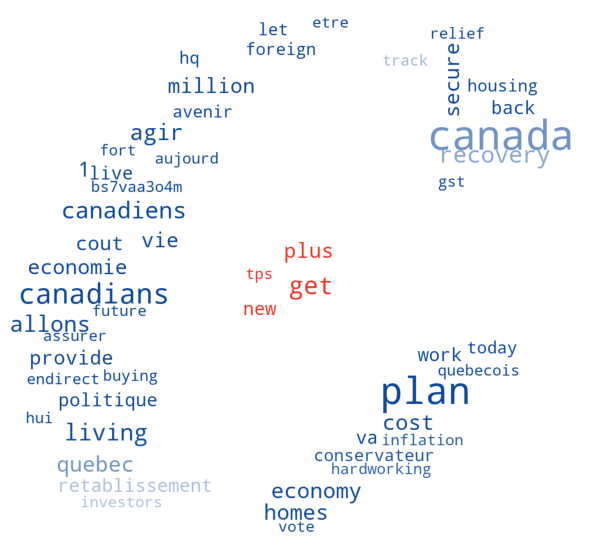

In [98]:
# Get the word count of Erin O'Toole's recent tweets
words = word_count(df_OToole_recent.text, tf_vectorizer_OToole)

# Load image of Conservative Party of Canada (CPC) Logo
cpc_mask = np.array(Image.open("cpc_logo.jpg"))

# Use colors from the CPC party logo
image_colors = ImageColorGenerator(cpc_mask)

# Generate word cloud
words_dict = words.set_index('words')['count'].to_dict()
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                mask=cpc_mask,
                min_font_size = 1).fit_words(words_dict) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud.recolor(color_func=image_colors)) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# save the WordCloud image
timestamp = dt.now().strftime("%Y%m%d_%H-%M-%S")
plt.savefig(timestamp + "_Erin_OToole_Tweets.png", dpi=300) 
plt.show() 

Then we will look at the most common words in each of the 5 topics, as determined by the LDA algorithm.

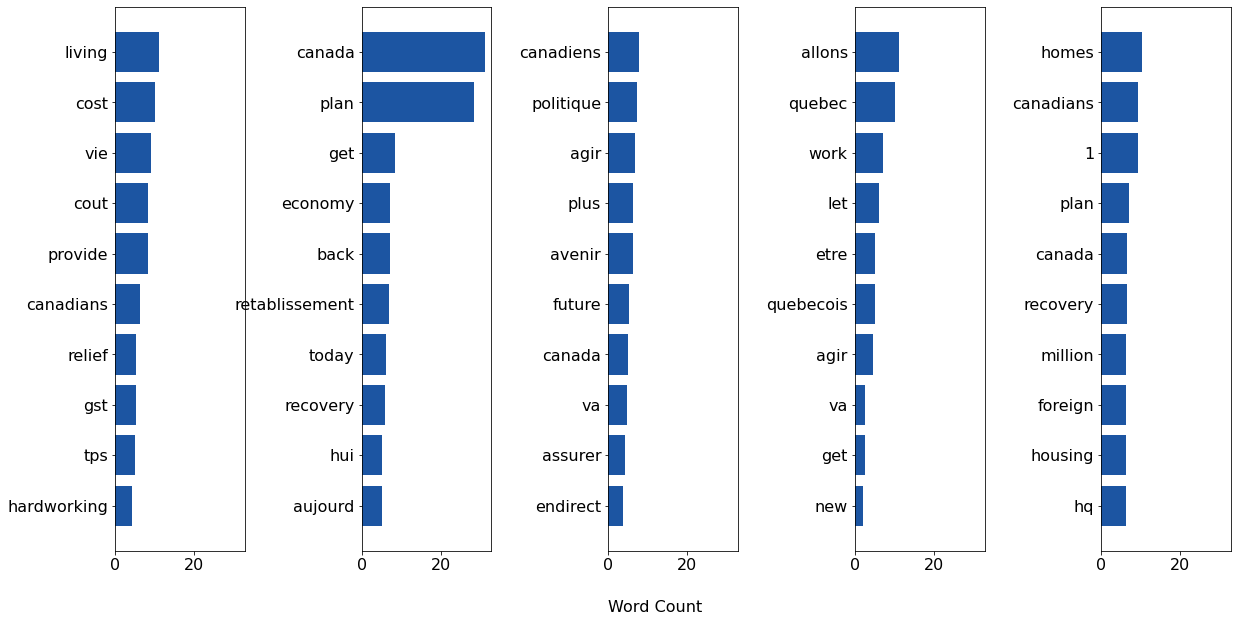

In [118]:
tf_feature_names = tf_vectorizer_OToole.get_feature_names()
plot_topic_top_words(lda_tf_OToole, tf_feature_names, n_topics, 10, color='#1C55A2')

### Justin Trudeau (LPC)

Once again we will first make a word cloud showing the most common words in the tweets.

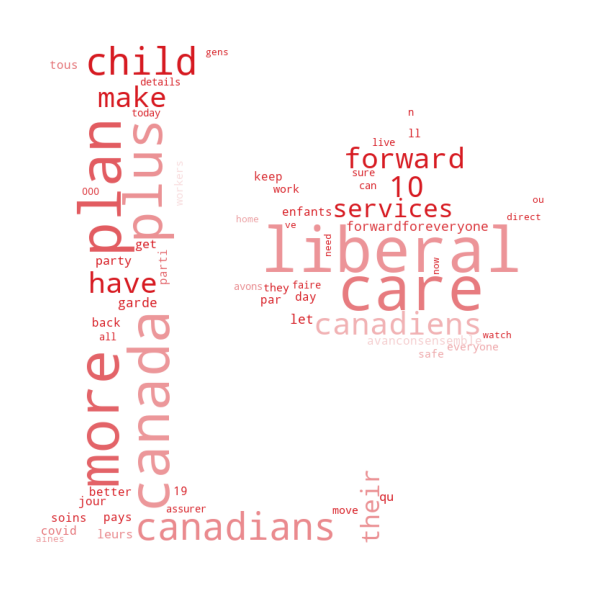

In [99]:
# Get the word count of Justin Trudeau's recent tweets
words = word_count(df_Trudeau_recent.text, tf_vectorizer_Trudeau)

# Load image of Liberal Party of Canada (LPC) Logo
lpc_mask = np.array(Image.open("lpc_logo.jpg"))

# Use colors from the LPC party logo
image_colors = ImageColorGenerator(lpc_mask)

# Generate word cloud
words_dict = words.set_index('words')['count'].to_dict()
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                mask=lpc_mask,
                min_font_size = 1).fit_words(words_dict) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud.recolor(color_func=image_colors)) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# save the WordCloud image
timestamp = dt.now().strftime("%Y%m%d_%H-%M-%S")
plt.savefig(timestamp + "_Justin_Trudeau_Tweets.png", dpi=300) 
plt.show() 

Then we will look at the most common words in each of the 5 topics, as determined by the LDA algorithm.

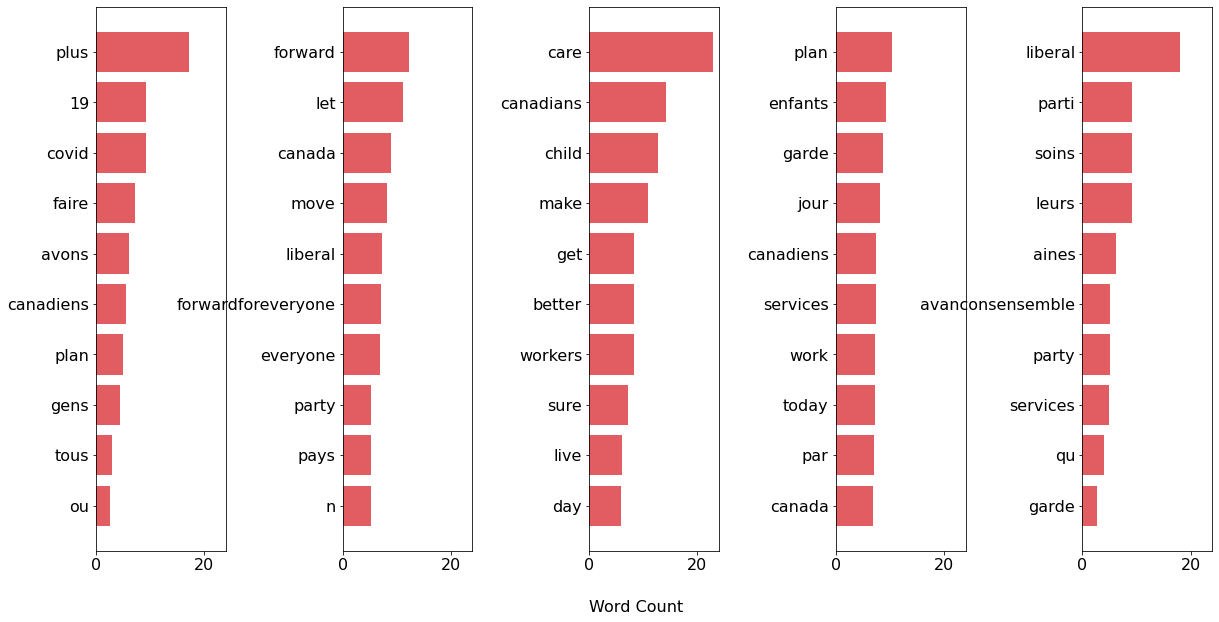

In [119]:
tf_feature_names = tf_vectorizer_Trudeau.get_feature_names()
plot_topic_top_words(lda_tf_Trudeau, tf_feature_names, n_topics, 10, color='#E25D62')